# Filtering tiles
We can reduce the compute time and prevent many false-positive errors by restricting the analysis to the tiles that are likely to contain sea ice. 

1. Analysis of the validation dataset
2. Examples with large images.

In [13]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images
include("../scripts/dev/validation_data.jl")

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`


_get_file (generic function with 1 method)

In [42]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c -> c.case_number == 31 && c.satellite == "aqua");

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [54]:
x = []
for case in dataset
    append!(x, [case])
    break
end

In [62]:
x[1].metadata

Dict{Symbol, Any} with 28 entries:
  :sea_ice_fraction           => 0.64
  :visible_floes              => "no"
  :visible_landfast_ice       => "no"
  :region                     => "barents_kara_seas"
  :cloud_category_manual      => "thin"
  :qa_reviewer                => "ethan"
  :center_x                   => 2187500
  :modis_cloud_error          => ""
  :start_date                 => Date("2015-04-28")
  :satellite                  => "aqua"
  :floe_obscuration           => ""
  :fl_reviewer                => ""
  :artifacts                  => "no"
  :psd_file                   => ""
  :visible_water              => missing
  :center_y                   => 362500
  :center_lon                 => 54.4092
  :init_case_number           => 84
  :cloud_fraction_manual      => 0.9
  :qa_analyst                 => "daniel"
  :case_number                => 31
  :month                      => 4
  :visible_sea_ice            => "yes"
  :mean_sea_ice_concentration => 0.538
  :landfast_obsc

In [63]:
tiles = IceFloeTracker.get_tiles(tc_img, 200)


2×2 Matrix{Tuple{UnitRange{Int64}, UnitRange{Int64}}}:
 (1:200, 1:200)    (1:200, 201:400)
 (201:400, 1:200)  (201:400, 201:400)

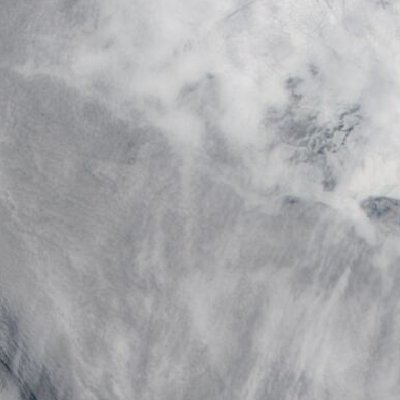

In [51]:
landmask = Gray.(case.modis_landmask) .> 0
tc_img .* .! landmask

In [106]:
"""Compute the fraction of non-ocean pixels covered by cloud"""
function ocean_cloud_fraction(cloudfrac, landmask)
    lm = vec(landmask)
    cf = vec(cloudfrac)[.!lm]
    length(cf) > 0 ? (return round(mean(cf), digits=3)) : (return NaN)
end

"""Compute the contrast by differencing the 99th and 1st percentile"""
function robust_contrast(img_band, landmask; min_pct=1, max_pct=99)
    lm = vec(landmask)
    band_data = vec(img_band)[.!lm]
    length(band_data) > 0 ? (return round(percentile(band_data, max_pct) - percentile(band_data, min_pct), digits=3)) : (return 0)
end

"""Compute the fraction of non-cloudy ocean pixels with band 2 brightness above a given threshold"""
function possible_clear_sky_sea_ice(band_2, landmask, cloudmask; possible_ice_threshold=75/255)
    ocean_nocloud = vec(.! (landmask .| cloudmask))
    b2 = vec(band_2)[ocean_nocloud]
    length(b2) > 0 ? (return round(mean(b2 .> possible_ice_threshold), digits=3)) : (return 0)
end

possible_clear_sky_sea_ice

In [102]:
test_markers = Gray.(load("../data/validation_dataset/modis_500km/tile_markers/001-baffin_bay-500km-20220911-aqua-250m-markers.png")) .> 0;
tc_image = RGB.(load("../data/validation_dataset/modis_500km/truecolor/001-baffin_bay-500km-20220911-aqua-250m-truecolor.tiff"));
fc_image = RGB.(load("../data/validation_dataset/modis_500km/falsecolor/001-baffin_bay-500km-20220911-aqua-250m-falsecolor.tiff"));
land_image = Gray.(load("../data/validation_dataset/modis_500km/landmask/001-baffin_bay-landmask.tiff"))
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)
cmask = LopezAcostaCloudMask(cloud_mask_settings...)
cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
landmask = land_image .> 0.1

# with 256 m pixels instead of our usual 250 m tiles, we have approx 98 pixels per 25 km.
tiles = IceFloeTracker.get_tiles(tc_image, 98)

# use the markers to make a checkerboard
for tile in filter(t -> maximum(test_markers[t...]) .> 0, tiles)
    test_markers[tile...] .= 1
end

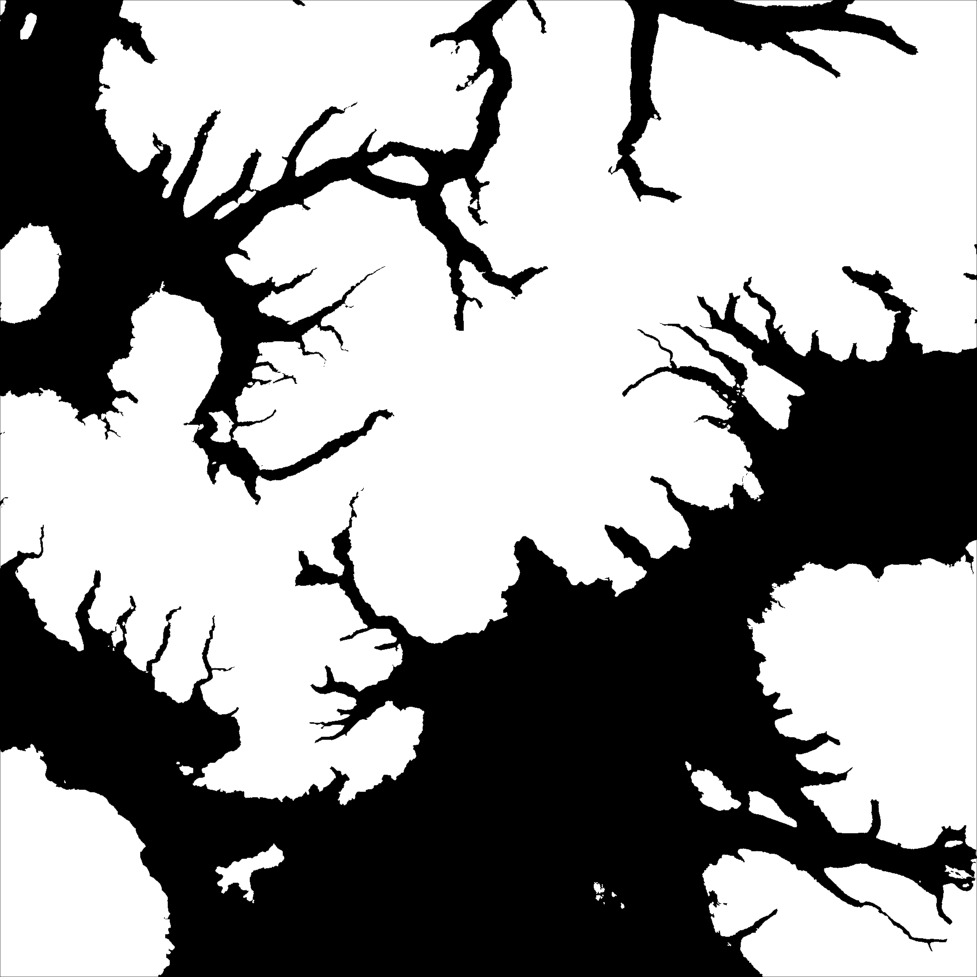

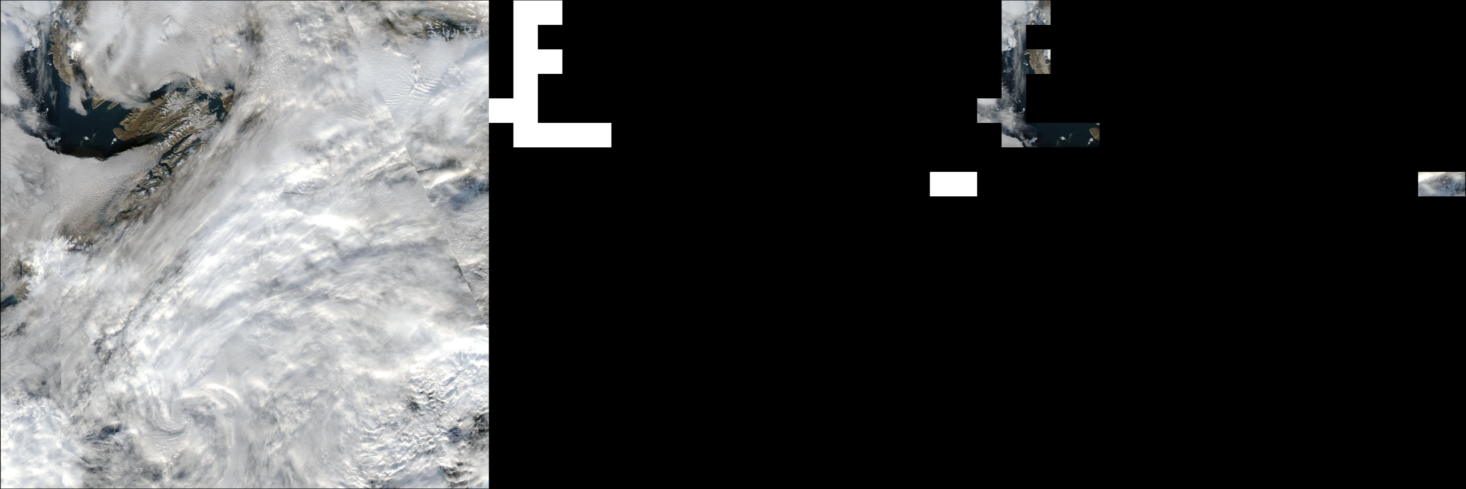

In [98]:
mosaicview(tc_image, Gray.(test_markers), tc_image .* test_markers, nrow=1)

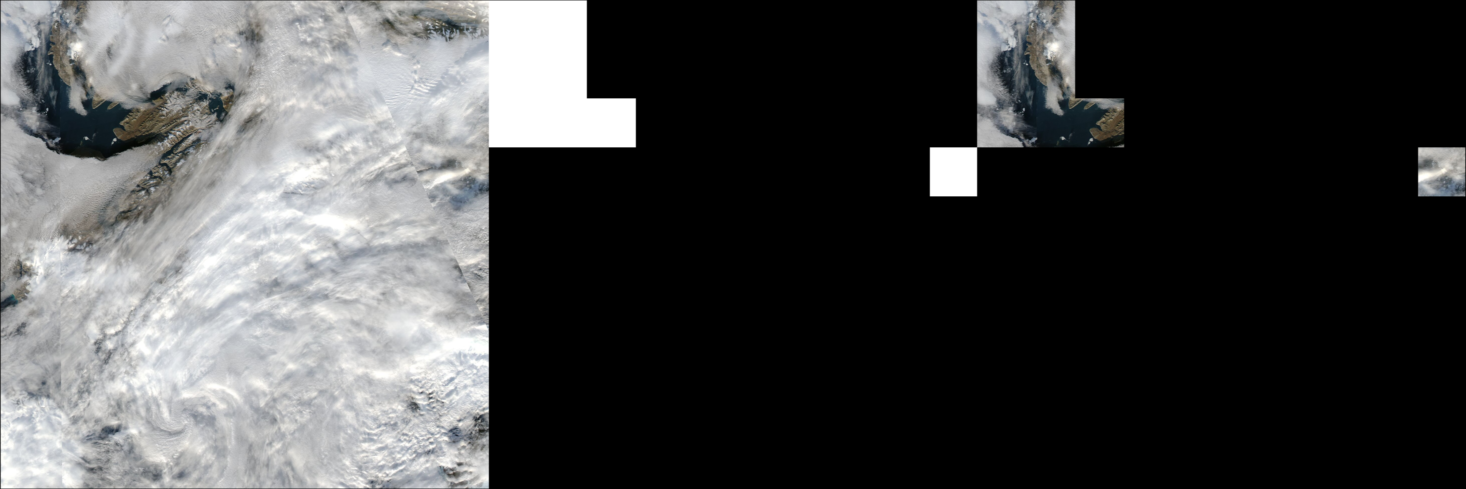

In [100]:
# We can also look at 50 km (or 100 km, or whichever) by selecting tiles containing markers
# using larger tile spacing.
tiles = IceFloeTracker.get_tiles(tc_image, 2*98)

# use the markers to make a checkerboard
for tile in filter(t -> maximum(test_markers[t...]) .> 0, tiles)
    test_markers[tile...] .= 1
end

mosaicview(tc_image, Gray.(test_markers), tc_image .* test_markers, nrow=1)

In [130]:
using Statistics 
using StatsBase

df = DataFrame(
               tile_index=Int16[],
               ground_truth=[],
               cloud_fraction=Float64[],                   
               land_fraction=Float64[],
               truecolor_band_1_contrast=Float64[],
               falsecolor_band_2_contrast=Float64[],
               falsecolor_band_7_contrast=Float64[],
               truecolor_band_1_entropy=Float64[],
               falsecolor_band_2_entropy=Float64[],
               falsecolor_band_7_entropy=Float64[],
               possible_sea_ice_fraction=Float64[]
               )

for (index, tile) in enumerate(tiles)
    push!(df, (
               tile_index = index,
               ground_truth = maximum(test_markers[tile...]) > 0,
               cloud_fraction = ocean_cloud_fraction(cloud_mask[tile...], landmask[tile...]),
               land_fraction = mean(landmask[tile...]),
               truecolor_band_1_contrast = robust_contrast(red.(tc_image[tile...]), landmask[tile...]),
               falsecolor_band_2_contrast = robust_contrast(green.(fc_image[tile...]), landmask[tile...]),
               falsecolor_band_7_contrast = robust_contrast(red.(fc_image[tile...]), landmask[tile...]),
               truecolor_band_1_entropy = Images.entropy(red.(tc_image[tile...]) .* .! landmask[tile...]), 
               falsecolor_band_2_entropy = Images.entropy(green.(fc_image[tile...]) .* .! landmask[tile...]),
               falsecolor_band_7_entropy = Images.entropy(red.(fc_image[tile...]) .* .! landmask[tile...]),
               possible_sea_ice_fraction = possible_clear_sky_sea_ice(
                                                green.(fc_image[tile...]),
                                                landmask[tile...],
                                                cloud_mask[tile...]))
            )
end

In [140]:
subset(df, :ground_truth)

Row,tile_index,ground_truth,cloud_fraction,land_fraction,truecolor_band_1_contrast,falsecolor_band_2_contrast,falsecolor_band_7_contrast,truecolor_band_1_entropy,falsecolor_band_2_entropy,falsecolor_band_7_entropy,possible_sea_ice_fraction
,Int16,Any,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5,true,0.941,0.272699,0.62,0.801,0.577,6.01709,6.24418,5.80211,0.107
2,21,true,0.978,0.0,0.486,0.647,0.529,6.25402,6.48611,5.90397,0.553
3,22,true,0.605,0.0,0.725,0.871,0.667,7.36035,7.62579,7.32339,0.586
4,23,true,0.289,0.0093711,0.627,0.667,0.541,6.96192,6.41196,6.49931,0.031
5,24,true,0.316,0.0,0.529,0.596,0.608,6.87035,6.1618,6.37008,0.001
6,25,true,0.543,0.02197,0.655,0.729,0.702,7.30672,6.77917,6.73505,0.026
7,26,true,0.659,0.192836,0.655,0.737,0.659,6.57373,6.28473,6.27478,0.031
8,41,true,0.726,0.342982,0.604,0.824,0.623,5.56766,5.8077,5.44474,0.587
9,43,true,0.069,0.832986,0.702,0.733,0.478,1.58588,1.01224,1.20426,0.025


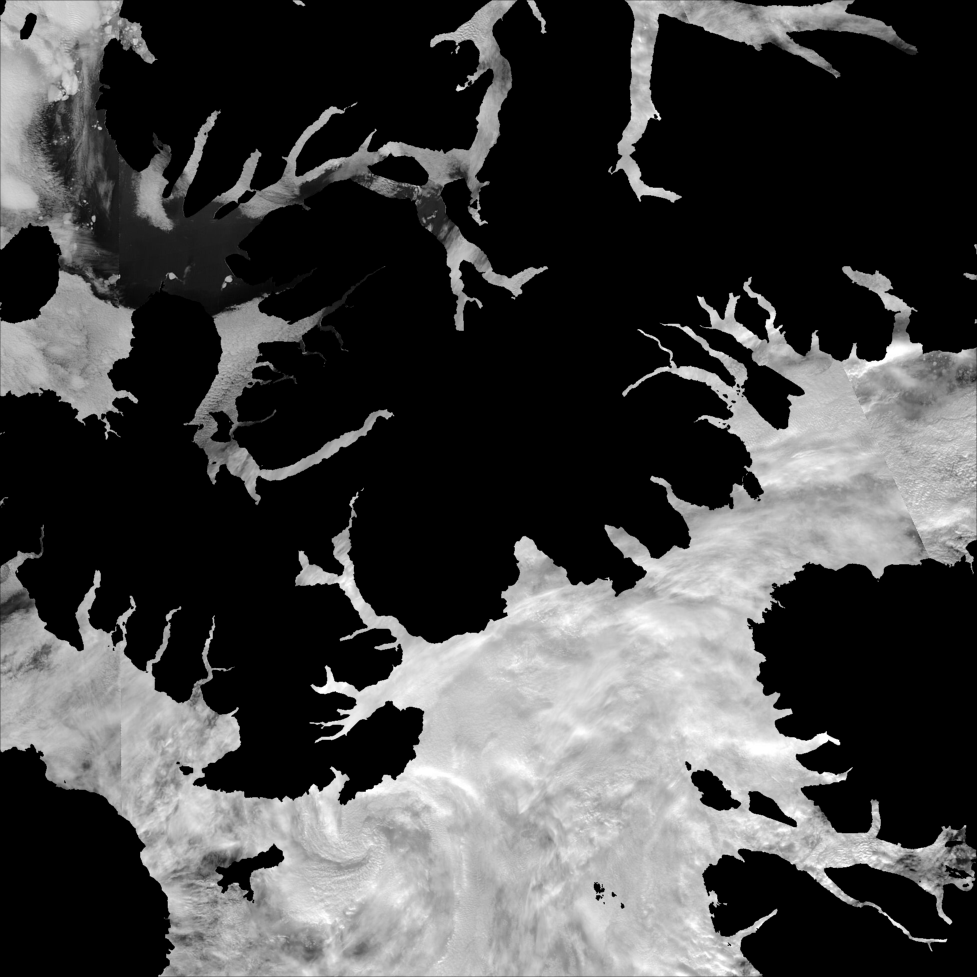

In [116]:
Gray.(green.(tc_image) .* .! landmask)

In [27]:
using StatsBase
robust_contrast(red.(tc_img), landmask)
ocean_cloud_fraction(cloudmask, landmask)
possible_sea_ice(green.(fc_img), landmask, cloudmask)

0.021

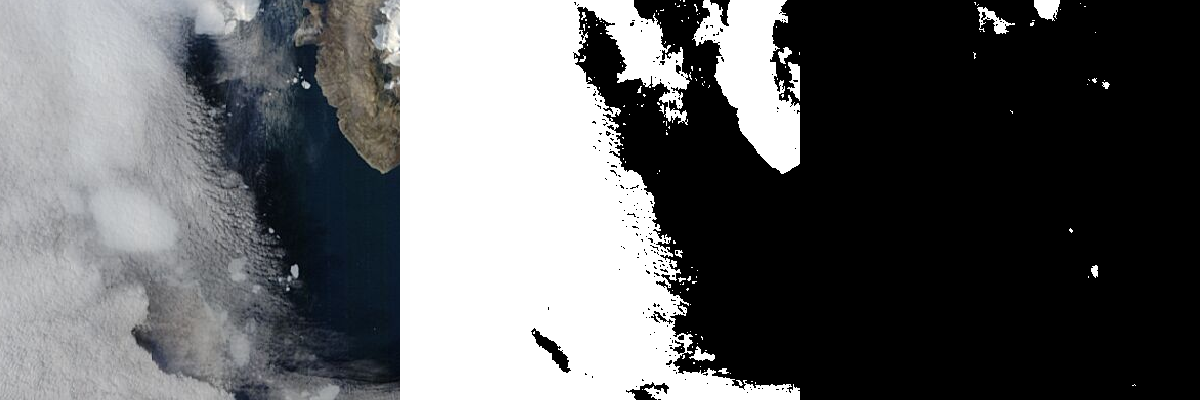

In [21]:
mosaicview(tc_img, Gray.(cloudmask), Gray.(green.(fc_img) .> possible_ice .&& .! (landmask .| cloudmask)), nrow=1)

In [76]:
# grid for the large images
# Image is 1953 by 1953 pixels (pixel is 256 m)
# Other images from project are 250 m / pixel.

using Images
grid = Gray.(zeros((1953, 1953)));
for i in range(1, 19)
    grid[i*98, 1:end] .= 1
    grid[1:end, i*98] .= 1
end
Images.save("../data/validation_dataset/modis_500km/25km_grid.png", Gray.(grid))

In [68]:
1953/98

19.928571428571427